# <center> Movie review sentiment analysis </center>

Notebook represents a solution to the recognition a sentiment polarity of a movie review problem. Task is to classify reviews on a specific movies into one of two categories: positive and negative according to its sentiment polarity.<br><br>
Notebook is splitted into following parts:
1. Reading and preprocessing data.
2. Exploratory data analysis.
3. Baseline solution using TF-IDF and logistic regression.
4. Solution using LSTM and word embeddings.
5. Conclusions.

Dataset used in solution is [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/). This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg). In the
labeled train/test sets, a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. Thus reviews with more neutral ratings are not included in the train/test sets.


## 1. Reading and preprocessing data.

There are two top-level directories [train/, test/] corresponding to
the training and test sets. Each contains [pos/, neg/] directories for
the reviews with binary labels positive and negative. Within these
directories, reviews are stored in text files named following the
convention [[id]_[rating].txt] where [id] is a unique id and [rating] is
the star rating for that review on a 1-10 scale. In solution we'll use only reviews itself without metainformation.

Assume clImdb_v1.tar.gz with data extracted into PATH. Import data to dataframe from text files.

In [1]:
import os
import pandas as pd
import numpy as np
#tfidf
from bs4 import BeautifulSoup
# import nltk
# nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install wordcloud
from wordcloud import WordCloud
import itertools
from wordcloud import tokenization
from typing import List
sns.set();
import urllib.request
import shutil
from zipfile import ZipFile

In [2]:
PATH = 'aclImdb/'

In [3]:
def load_reviews(path):
    def load_category(cat_path):
        reviews = []
        for filename in os.listdir(cat_path):
            if filename.endswith(".txt"):
                with open(os.path.join(cat_path, filename), 'r') as file:
                    reviews.append(file.read())
        return reviews
    
    df_pos = pd.DataFrame({'Review': load_category(os.path.join(path, 'pos')), 'Target': 1})
    df_neg = pd.DataFrame({'Review': load_category(os.path.join(path, 'neg')), 'Target': 0})
    return pd.concat([df_pos, df_neg])

In [4]:
train_df = load_reviews(os.path.join(PATH, 'train'))
test_df = load_reviews(os.path.join(PATH, 'test'))

train_df.head()

,Review,Target
0,"Richard Dreyfuss stars in ""Moon Over Parador,""...",1
1,"Once in the Life means that once a hoodlum, al...",1
2,Lots of reviews on this page mention that this...,1
3,The Theory Of Flight is an engaging character ...,1
4,I can understand those who dislike this movie ...,1


Separate data and target feature for further convenience.

In [5]:
X_train = train_df.drop('Target', axis=1)
y_train = train_df['Target']
X_test = test_df.drop('Target', axis=1)
y_test = test_df['Target']

See how specific review looks like.

In [31]:
X_train['Review'].values[0]

'Richard Dreyfuss stars in "Moon Over Parador," a 1988 Paul Mazursky film also starring Raul Julia, Sonia Braga, Jonathan Winters and Charo. Dreyfuss plays a New York actor, Jonathan Nolan, in the Caribbean country of Parador to make a film. When the dictator dies suddenly, the Secret Police Chief (Julia) who is the one actually controlling the dictator and the country, drafts Jonathan to play the dictator, having noticed the resemblance between them. Soon Jonathan is ensconced in the palace as Alphonse Simms, and Simms\' prostitute girlfriend Madonna (Braga) who realizes the switch promises to help him in any way she can.<br /><br />Mazursky, who appears in drag as Simms\' mother, gives us a look at how the CIA operates in third world countries. The Winters character, supposedly a salesman, is actually a CIA operative. The film, however, flirts with but doesn\'t really tread on very serious ground and is more of a send-up, and a funny one at that.<br /><br />Richard Dreyfuss does a fa

It is obvious that raw data is dirty (e.g. HTML tags) and needs to be preprocessed. Define preprocess function of a single review, which includes converting to lowercase, removing non-word tokens, stopwords and lemmatizing tokens.

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_tags(text):
    return BeautifulSoup(text, "lxml").text

def preprocess_text(text, stop_words=stop_words, lemmatizer=lemmatizer):
    # Remove HTML tags
    cleaned = remove_tags(text)
    
    # Tokenize lowered and remove punctuation
    tokens = word_tokenize(cleaned.lower())
    tokens = filter(lambda tok: any(map(lambda ch: ch.isalpha(), tok)), tokens) #!isalpha
    
    # Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    
    # Remove endings and converted stopwords('d, 're, 's, 'll, .., wa, n't)
    lemmatized_no_endings = filter(lambda tok: tok[0].isalpha() or tok in ['wa', 'n\'t'],
                                   lemmatized_tokens)
    
    # Remove stopwords
    useful_tokens = filter(lambda tok: not (tok in stop_words), lemmatized_no_endings)
    
    return useful_tokens

## 2. Exploratory data analysis

Dataset is balanced - number of positive samples is the same as number of negative samples.

In [14]:
y_train.value_counts()

1    12500
0    12500
Name: Target, dtype: int64

Look at target distribution on some features that doesn't use words itself like number of words in each review. But first apply our preproces function to texts.

In [103]:
preprocessed_reviews = X_train['Review'].apply(lambda text: list(preprocess_text(text)))
word_count = preprocessed_reviews.apply(lambda text : len(list(text)))

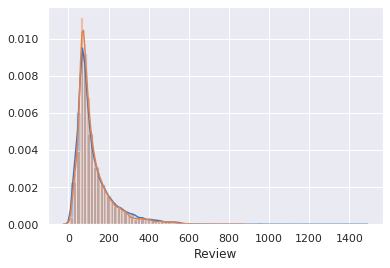

In [28]:
sns.distplot(word_count.loc[y_train == 1])
sns.distplot(word_count.loc[y_train == 0])
fig.set_axis_labels('Colors', 'Values')

There is no significant difference between review length in different classes.

Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. Build word clouds for positive and negative reviews.

In [116]:
def plot_wordcloud(reviews: List[List[str]], title: str) -> None:
    flattened_reviews_list = list(itertools.chain.from_iterable(reviews))
    frequency_dict = tokenization.process_tokens(flattened_reviews_list)[0]
    
    wordcloud = WordCloud(width=800, height=400)
    wordcloud.fit_words(frequency_dict)
    fig = plt.figure(figsize=(30,20))
    fig.suptitle(title, fontsize=32)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

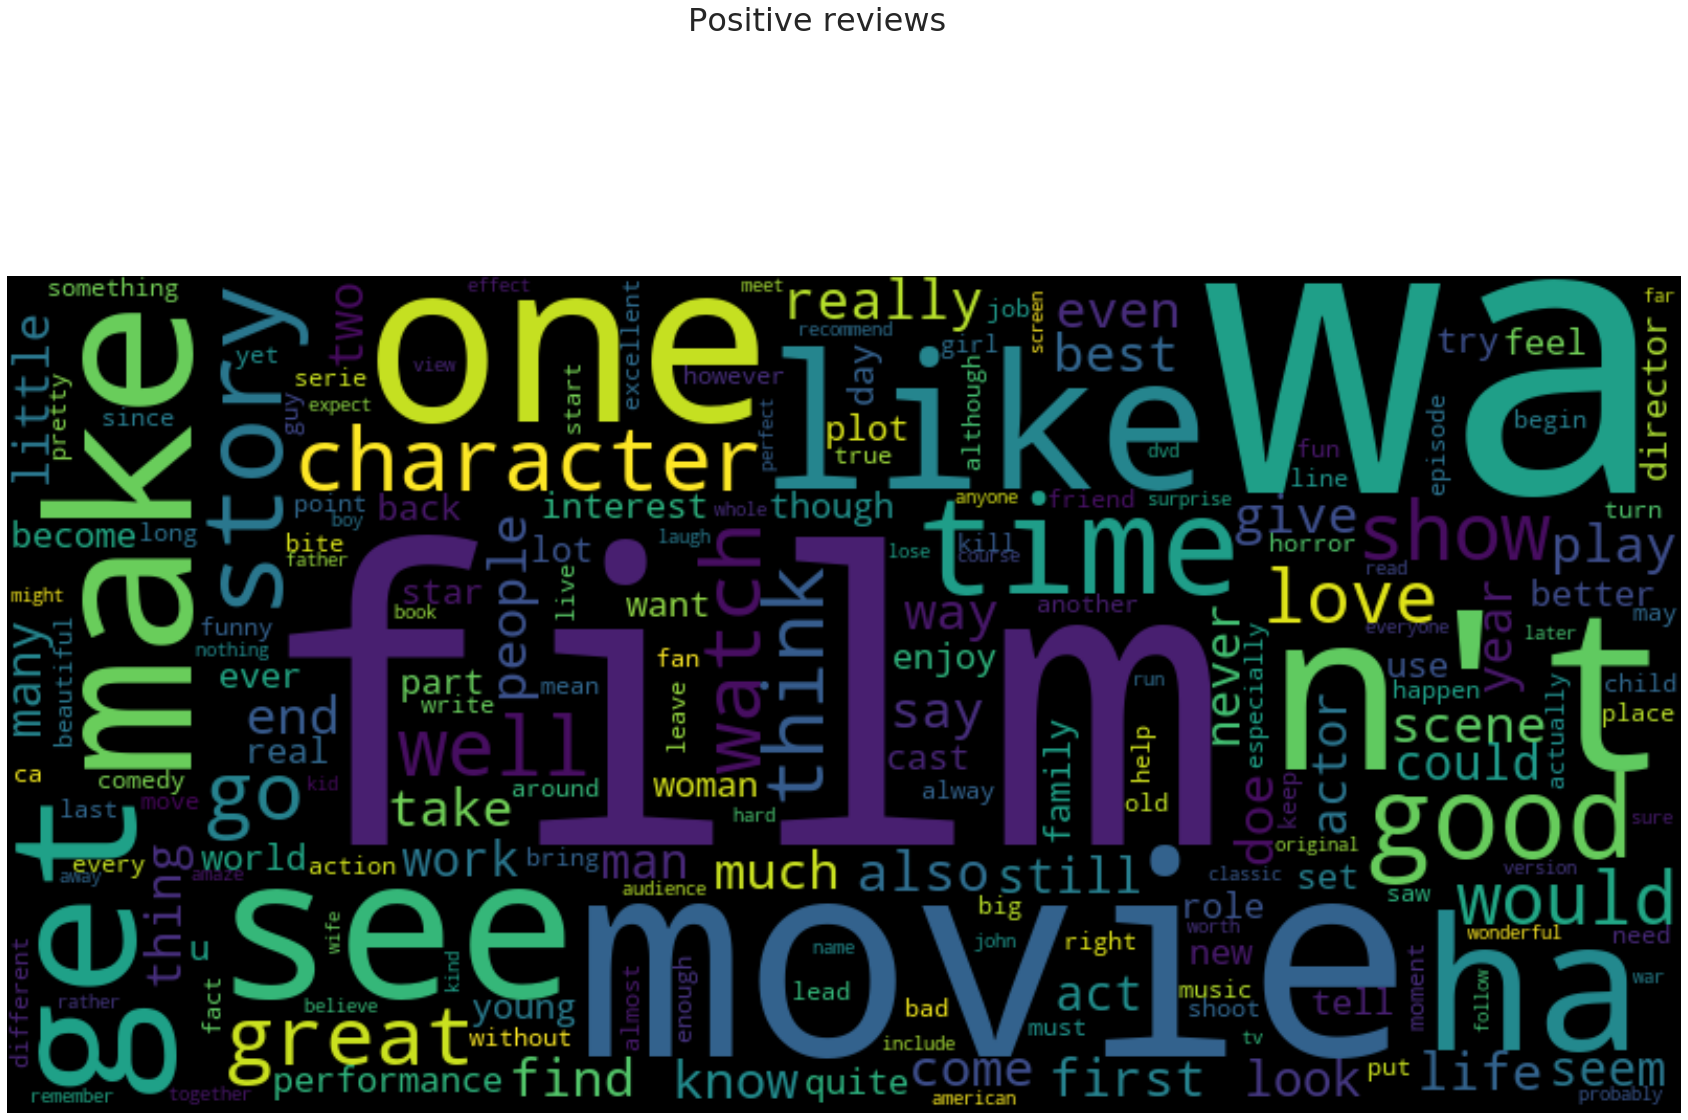

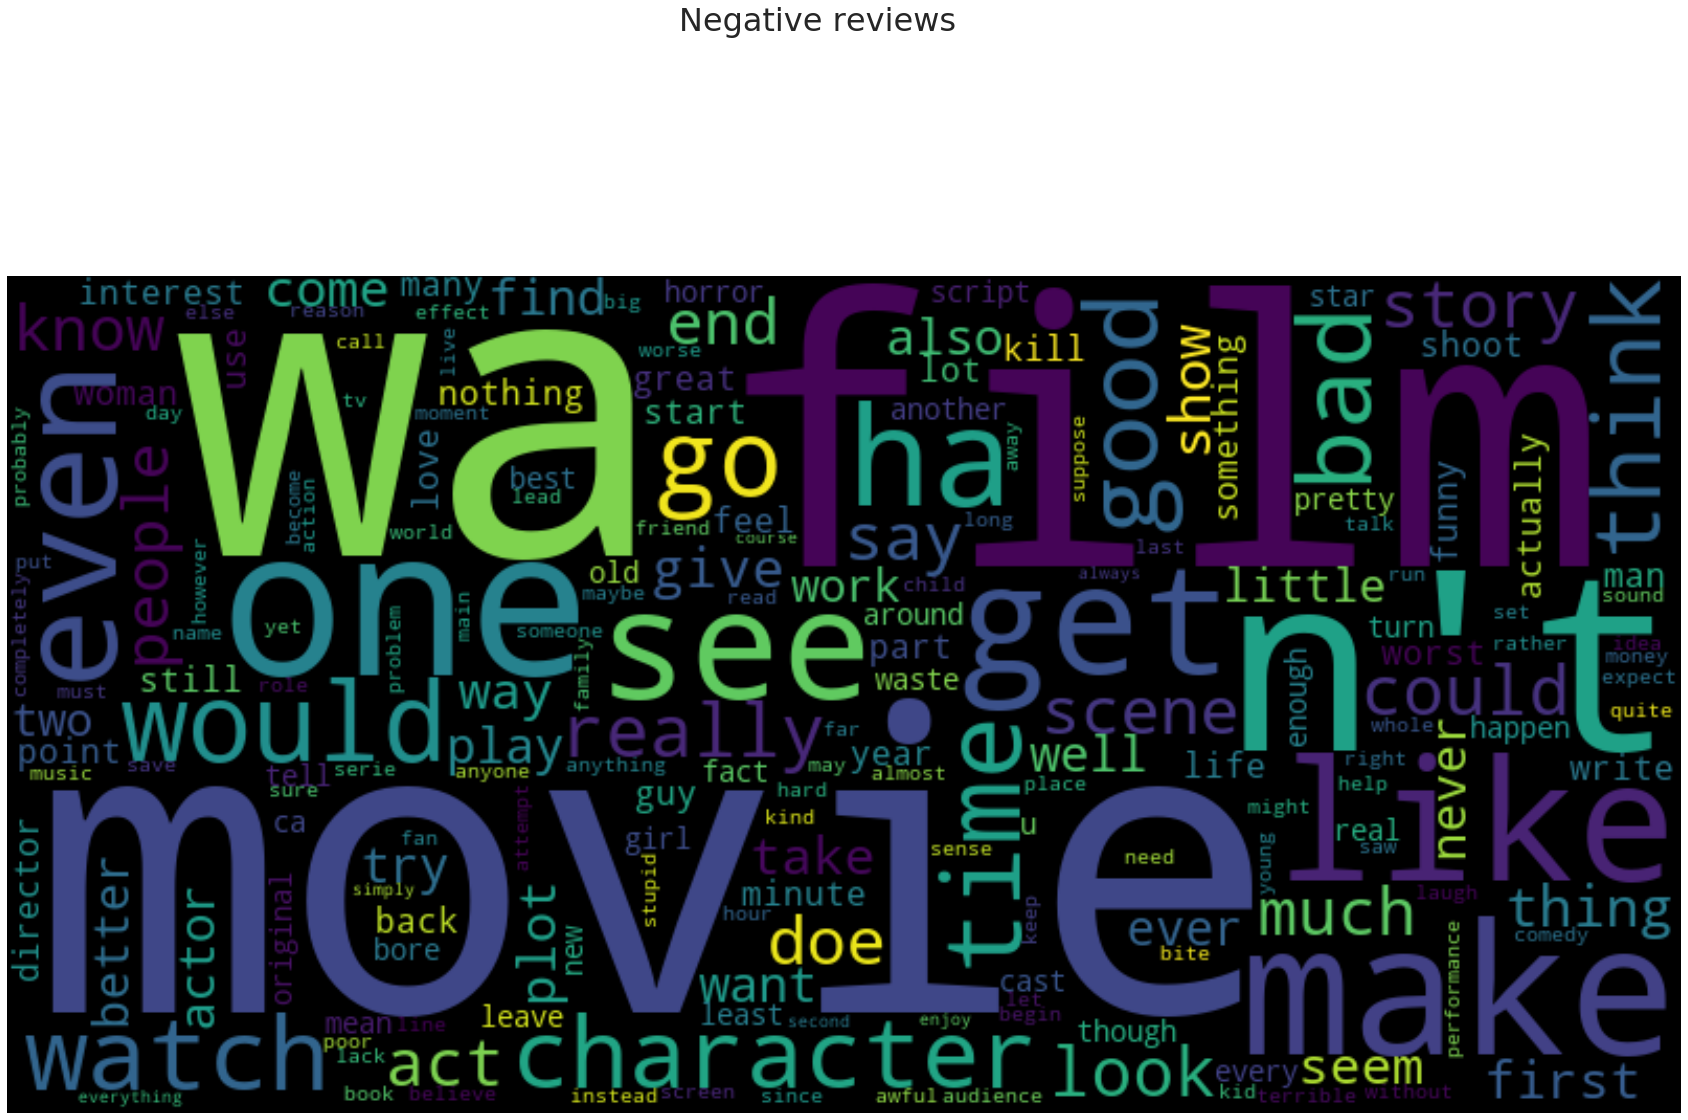

In [117]:
plot_wordcloud(reviews=preprocessed_reviews.loc[y_train==1], title='Positive reviews')
plot_wordcloud(reviews=preprocessed_reviews.loc[y_train==0], title='Negative reviews')

Both classes share common words, but there are a lot of subjective words in each class like <em>good, best, fun</em> in positive and <em>poor, lack, bore, worst</em> in negative. Hope this words will help to predict sentiment polarity of reviews.

## 3. TF-IDF logistic regression baseline.

Although we performed raw text preprocessing, our logistic regression model will not be able to use raw words as features. Hence, source texts needs to be mapped (encoded) to feature space, acceptable by model. There are various approaches for text encoding: BOW, TF-IDF, word embeddings and so on. TF-IDF will be used in baseline solution below.

In [98]:
vectorizer = TfidfVectorizer(tokenizer = preprocess_text)
X_train_vec = vectorizer.fit_transform(X_train['Review'].values)
X_test_vec = vectorizer.transform(X_test['Review'].values)

Define cross-validation scheme and quality metrics to evaluate logistic regression performance and perform cross-validation on train data. Classes are balanced, but data not shuffled due to the way we loaded it. Let's use stratified k-fold on 5 folds. Now use default logistic regression, but later see how hyperparameter tuning will improve current result. Classes are balanced and wecare about performance in identifying each class equally so ROC AUC scoring is a good fit.

In [99]:
%%time
clf = LogisticRegression(solver='lbfgs')
cv = cross_val_score(clf, X_train_vec, y_train, cv=5, scoring='accuracy')

CPU times: user 15.1 s, sys: 529 ms, total: 15.7 s
Wall time: 8.67 s


In [20]:
%%time
clf = LogisticRegression(solver='lbfgs')
cv = cross_val_score(clf, X_train_vec, y_train, cv=5, scoring='roc_auc')

CPU times: user 13.3 s, sys: 445 ms, total: 13.7 s
Wall time: 7.02 s


In [100]:
print(f"Cross-validation scores - {cv}")
print(f"Cross-validation mean - {cv.mean()}")
print(f"Cross-validation std - {cv.std()}") 

Cross-validation scores - [0.8816 0.88   0.8858 0.8838 0.8908]
Cross-validation mean - 0.8844000000000001
Cross-validation std - 0.0037544640096823464


Calculate ROC AUC score on validation set.

In [101]:
clf.fit(X_train_vec, y_train)
accuracy_score(y_test, clf.predict(X_test_vec))

0.87712

In [21]:
clf.fit(X_train_vec, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test_vec)[:,1])

0.9492026112

We plot validation curve which shows the training scores and validation scores of logistic regression for different values of the model parameter C. For very low values of C, you can see that both the training score and the validation score are low. This is called underfitting. Medium values of C will result in high values for both scores, i.e. the classifier is performing fairly well. If C is too high, the classifier will overfit, which means that the training score is good but the validation score is poor.

In [ ]:
def plot_val_curve(train_scores, valid_scores, param_range):
    lw = 2
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(valid_scores, axis=1)
    test_scores_std = np.std(valid_scores, axis=1)
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

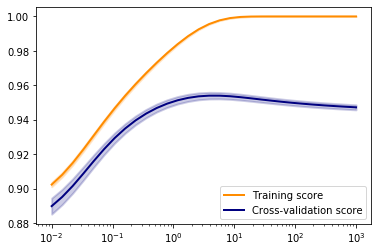

In [174]:
C_range = np.logspace(-2, 3, 30)
train_scores, valid_scores = validation_curve(LogisticRegression(solver='liblinear'), 
                                              X_train_vec, y_train,
                                              "C",
                                              C_range,
                                              cv=3,
                                              scoring="roc_auc")
plot_val_curve(train_scores, valid_scores, C_range)

Analyzing validation curve we can specify range of C parameter more accurately and continue hyperparameter tuning with grid search. TF-IDF also has hyperparameter to tune (like n-gram range, max_features). Good option (though time-consuming) would be building general pipeline for TF-IDF vectorization and fitting and tuning hyperparameters for all pipeline.

One of the major advantages of linear models is their interpretability. Such models allows to explore their coefficients and see which features gives most value to result prediction. In our case we can inspect which words are important indicators of review being positive or negative. More demonstative is to visualize coefficients in a way below. 

In [22]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients],
               rotation=60, ha="right");

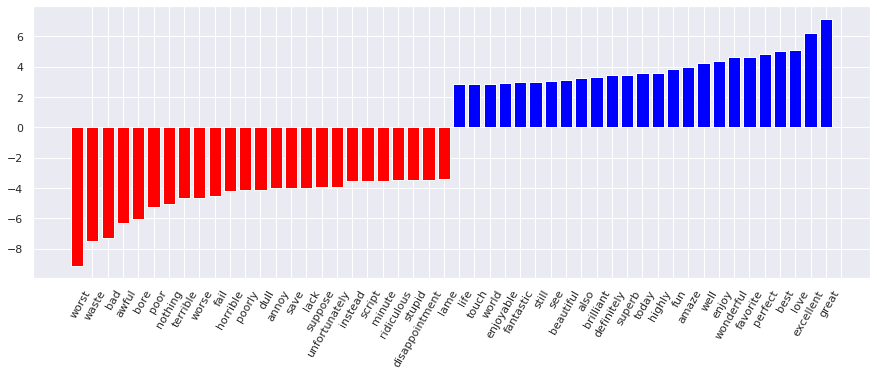

In [23]:
visualize_coefficients(clf, vectorizer.get_feature_names())

Actually there is a clear logic behind plot and the model learned it.

## 4. Solution using LSTM and word embeddings.

Although the baseline shows good results, it contains a number of drawbacks. TF-IDF generates large and sparse feature space and doesn't take into account context of words, relying only on their presence in document. We'll leverage vector semantics approach by using word embeddings.<br> 
According Jurafsky, language is an inherently temporal phenomenon. When we comprehend and produce spoken language, we are processing continuous input streams of indefinite length. We'll use RNNs to deal directly with the temporal aspect of language.

GloVe is powerful algorithm for obtaining vector representations for words. We'll use pretrained embeddings (Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors)

LSTM architecture is generally a good choice for many language applications as it tends to save more distant information than simple RNNs does. It can be important for language processing.

In [7]:
import sys
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding,  Bidirectional
from keras.models import Model, Sequential
from keras.initializers import Constant

Using TensorFlow backend.


In [8]:
GLOVE_FILENAME = 'glove.6B.200d.txt'
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 200

def get_embeddings(url):
    with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
    with ZipFile('glove.6B.zip', 'r') as zipObj:
        zipObj.extract(GLOVE_FILENAME, path=None, pwd=None)

Download and prepare embeddings.

In [31]:
get_embeddings('http://nlp.stanford.edu/data/glove.6B.zip')
embeddings_index = {}
with open(GLOVE_FILENAME) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

Keras uses it's own tokenizer. We need only remove tags from texts.

In [9]:
X_train_no_tags = X_train['Review'].apply(remove_tags)
X_test_no_tags = X_test['Review'].apply(remove_tags)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_no_tags)

sequences_train = tokenizer.texts_to_sequences(X_train_no_tags)
sequences_test = tokenizer.texts_to_sequences(X_test_no_tags)

data_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

In [32]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

We'll use fixed embedding layer with pretrained embeddings represented by constant embedding matrix. Next goes 5-word window convolution layer with max over time pooling (standard approach to get single embedding vector from windows). Result vector will be an input to LSTM. Output layer consists of two neurons with softmax activation.

In [33]:
input_sequences = Input(shape = (MAX_SEQUENCE_LENGTH,))
initial_dropout = 0.2

embedding_layer = Embedding(input_dim = len(tokenizer.word_index) + 1, 
                            output_dim = EMBEDDING_DIM,
                            weights = [embedding_matrix],
                            input_length = MAX_SEQUENCE_LENGTH,
                            trainable=False)

X = embedding_layer(input_sequences)
X = Dropout(0.2)(X)

dropout_W = 0
dropout_U = 0

X = LSTM(128, dropout = dropout_W, recurrent_dropout = dropout_U)(X)
X = Dropout(0.2)(X)
outputs= Dense(1, activation='sigmoid')(X)
model = Model(inputs = input_sequences, outputs = outputs)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(data_train, y_train,
          batch_size=64,
          epochs=3,
          validation_split=0.1, 
          shuffle=True)

Train on 22500 samples, validate on 2500 samples
Epoch 1/3
22500/22500 [==============================] - 346s 15ms/step - loss: 0.5195 - accuracy: 0.7391 - val_loss: 0.2392 - val_accuracy: 0.9332
Epoch 2/3
22500/22500 [==============================] - 337s 15ms/step - loss: 0.4002 - accuracy: 0.8210 - val_loss: 0.5635 - val_accuracy: 0.7824
Epoch 3/3
22500/22500 [==============================] - 343s 15ms/step - loss: 0.3282 - accuracy: 0.8607 - val_loss: 0.3146 - val_accuracy: 0.8552


Infer result on test set and calculate scores to compare model with baseline solution.

In [34]:
predictions = model.predict(data_test, batch_size = 128)

In [37]:
print(f"ROC AUC score on test - {roc_auc_score(y_test, predictions)}")

ROC AUC score on test - 0.9482751264


## 5. Conclusions.

Sentiment polarity of a movie review problem was approached in several ways: with classical baseline and neural solutions. Both models results in good performance scored using ROC AUC. Neural approach provides almost same results, but is more resource-consuming to train and is less interpretable than baseline. During neural model improvements a lot of different architectures was applied. It turned out that they are prone to overfit, so dropout layers were added in result model. We conclude that target relationship is not too complex in linearity terms and linear methods perform well on this task. Further work enlisted in Todo section is to try some state-of-the-art models like BERT.
<br><br>Todo:<br>
* oh LSTM
* Try BERT